# Building and Testing ray tracing with satGEM fields

## Ray Equations
- Add revised equations
- Figure out where nans are coming from in distance vectors in results
    - Is this also happening in the full ray tracing with satgem?
    



### Revised equations


Intrinsic frequency becomes: $\omega_0 = \omega - \big (U(z,t)k + V(x,t)l \big )$ 

The revised 4D ray equations (group speeds) are:
<hr>
$$C_{gx} = \frac{\omega_0^2 - f^2}{\omega} \frac{m^2}{k(k^2 + l^2 m^2)} + U(x,y,z) $$

$$\frac{d_gy}{dt} \equiv \frac{\omega_0^2 - f^2}{\omega}
\frac{m^2}{l(k^2 + l^2 m^2)} + V(x,y,z) $$

$$\frac{d_gz}{dt} \equiv \frac{\omega_0^2 - f^2}{\omega} \frac{-m}{(k^2 + m^2 +l^2)} + 0 $$
<hr>

and rate of change of wave parameters:

<span  style="color:blue">**How will $k$ and $l$ vary in space and time now?**</span>.

$$ \frac{d_gk}{dt} \equiv  -\bigg(\frac{\delta\Omega}{\delta x}\bigg) \equiv 0 $$

** Why does vertical wavenumner vary with shear?**

$$ \frac{d_gm}{dt} \equiv  -\bigg(\frac{\delta\Omega}{\delta z}\bigg) \equiv  -k\frac{\delta U(x,y,z,t)}{\delta z}$$




In [3]:
# Using the ray tracing model
%matplotlib inline
import ray_tracing_satGEM as rt
from datetime import datetime, timedelta
import warnings
# import cmocean
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import gsw
import data_load
import warnings
import oceans as oc
warnings.simplefilter("ignore")
plt.rcParams.update({'font.size':14})

# Create wave object
towyo_date =  datetime(2012, 2, 28, 21, 33, 44)
gem = rt.satGEM_field()
k0 = 0.000379449
l0 = -0.000395896
m0 = -0.0062492
w0 = -0.00014730
lon = -49.23690843
lat = -53.56228373
wave = rt.Wave(k=k0, l=l0, m=m0, w0=w0, z0=1500,t0=towyo_date,
               lat=lat, lon=lon
              )

# check that the wave has the right properties
wave.properties()

Wave Properties:
---------------
    k: [0.00037945]
    l: [-0.0003959]
    m: [-0.0062492]
    kh: [[0.00054838]]
    Frequency: [-0.0001473]



## Testing
- In order to test the ray tracing setup, several test cases are run. The test cases are:
    1. Fully Uniform N2 and Velocity
    2. Fully Uniform N2 and depth varying only Velocity
    3. Depth Varying only N2 and Fully Uniform velocity
    4. Depth varying only N2 and velocity
    
### Test Case 1: Unifrom N2 and Velocity

#### Generating the test fields
Rather than create new datasets for each test case, a copy of the run_tracing function which does the actual integration will be used here rather than imported from the ray tracing module so velocity and N2 profiles can be modified as needed. The time-stepping method will remain identical.


In [27]:
def run_tracing_testing(wave, satGEM, N2_test=None,
                        u_test=None, v_test=None,
                        n2grid=None, uvGrid=None,
                        time_direction='forward', 
                        duration=24, tstep=10, status=False):
    """
    Runs ray tracing using the wave 
    objects and gem field objects with option for
    forward and backwards time finite differenceing steps. 

    Parameters
    ----------
    wave: Wave object with all initial wave
        features(i.e. wavenumbers, frequency, starting position)
    satGEM: satGEM object for accessing satGEM and bathymetry data
    N2: Test N2 profile
    U: test U profile
    V: test V profile. 
    time_direction: Direction in time to run ray tracing
                    ('reverse' or 'forward')
    duration: duration to run ray tracing (HOURS)
    tstep: time step (SECONDS)
    status: gives status updates (keep False unless you want a million messages)

    Returns
    -------
    wave.results: stores all results into a dictionary attached to 
        the initial wave object as 1D arrays
    
    results keys:
        x: x distance (meters) 
        y: y distance (meters)
        z: z distance (meters)
        k: zonal wavenumber
        l: meridional wavenumber
        m: vertical wavenumber
        omega: wave frequency
        lat: wave's latitude
        lon: wave's longitude
        cgx: horizontal (x direction) group speed
        cgy: horizontal (y direction) group speed
        cgz: vertical group speed
        bathy: bathymetry below wave
        N2: Buoyancy frequency along wave path
        N2_grid: pressure grid corresponding to N2
        time: time vector as datetime type
        elapsed_time: time vector as seconds elapsed 


    """

    # get initial values from wave object
    k = wave.k[:]
    l = wave.l[:]
    m = wave.m[:]
    Omega = wave.w0
    lat = wave.lat0
    lon = wave.lon0
    z = wave.z0[:]
    x = float(0)
    y = float(0)

    x_all = []
    y_all = []
    z_all = []
    k_all = []
    l_all = []
    m_all = []
    om_all = []
    lat_all = []
    lon_all = []
    cgx = []
    cgy = []
    cgz = []
    bathy = []
    N2_all = []
    N2_grid = []


    # add start values (theres probably a better way to do this)
    x_all.append(x)
    y_all.append(y)
    z_all.append(z)
    k_all.append(k)
    l_all.append(l)
    m_all.append(m)
    om_all.append(Omega)
    lat_all.append(lat)
    lon_all.append(lon)

    start_time = wave.t0 


    # Time arrays and start time in satgem field. 
    if time_direction == 'reverse':
        end_time = start_time - timedelta(hours=duration)
        tstep = -tstep
    elif time_direction == 'forward':
        end_time = start_time + timedelta(hours=duration)
        
    else:
        raise ValueError("Invalid time direction \
                            - accepts 'forward' or 'reverse'")

        
    time = np.arange(start_time, end_time, timedelta(seconds=tstep)).astype(datetime) # create time vector (seconds)

    # start time, depth, lat, and lon index in satGEM field
    
    # lon_idx, lat_idx, z_idx,\
    #         t_idx, clon_idx, clat_idx = satGEM.locate(lon, lat, z, time[0])
    # Run loop for tracing

    for i, t in enumerate(time[:-1]):
        
        f = gsw.f(lat)
        
        # list with [lon, lat, depth, time, centerlon, centerlat] indices
        lon_idx, lat_idx, z_idx,\
            t_idx, clon_idx, clat_idx = satGEM.locate(lon, lat, z, t)
        
        # satGEM values
        # Vertical N2 profile at current location (check if test profile is given)
        if N2_test is not None:
            idx_n = np.argmin(np.abs(n2grid.flatten() - z))
            N2 = N2_test.flatten()[idx_n]
            
        else:
            N2_vert, p_grid = gsw.Nsquared(satGEM.sal[lon_idx, lat_idx, :, t_idx],
                                  satGEM.temp[lon_idx, lat_idx, :, t_idx],
                                  satGEM.depth_grid[:,:].flatten(),lat[:],
                                  axis=-1)

            N2_all.append(N2_vert.flatten())
            N2_grid.append(p_grid.flatten())


            idx_n = np.argmin(np.abs(p_grid.flatten() - z))
            N2 = N2_vert.flatten()[idx_n]

        # Get flow speed
        if u_test is not None:
            idx = np.argmin(np.abs(uvGrid.flatten() - z))
            u = u_test.flatten()[idx]
        else:
            u = satGEM.u[lon_idx, clat_idx, z_idx, t_idx]
            
        if v_test is not None:
            idx = np.argmin(np.abs(uvGrid.flatten() - z))
            v = v_test.flatten()[idx]
        else:
            v = satGEM.v[clon_idx, lat_idx, z_idx, t_idx]
        

        # Check 1 (these have to be done before calculations)
        if not np.isfinite(N2):
            print('N2 error')
            x_all.append(x)
            y_all.append(y)
            z_all.append(z)
            k_all.append(k)
            l_all.append(l)
            m_all.append(m)
            om_all.append(Omega)
            lat_all.append(lat)
            lon_all.append(lon)
            cgx.append(dx / tstep)
            cgy.append(dy / tstep)
            cgz.append(dz / tstep)
            bathy.append(bottom)
            break

        
        if not np.isfinite(u):
            print('u error')
            x_all.append(x)
            y_all.append(y)
            z_all.append(z)
            k_all.append(k)
            l_all.append(l)
            m_all.append(m)
            om_all.append(Omega)
            lat_all.append(lat)
            lon_all.append(lon)
            cgx.append(dx / tstep)
            cgy.append(dy / tstep)
            cgz.append(dz / tstep)
            bathy.append(bottom)
            break
        
        if not np.isfinite(v):
            print('v error')
            x_all.append(x)
            y_all.append(y)
            z_all.append(z)
            k_all.append(k)
            l_all.append(l)
            m_all.append(m)
            om_all.append(Omega)
            lat_all.append(lat)
            lon_all.append(lon)
            cgx.append(dx / tstep)
            cgy.append(dy / tstep)
            cgz.append(dz / tstep)
            bathy.append(bottom)
            break
        
        
        # Finite differencing 

        # X step
        dx = tstep * rt.CGx(N2, Omega, k, l, m, u, f)
        if not np.isfinite(dx):
            print('dx error')
            print('N2: {}'.format(N2))
            print('k: {}'.format(k))
            print('Omega: {}'.format(Omega))
            print('u: {}'.format(u))
            print(i)
            break
        x  = x + dx # use this form instead of x+= because it modifies old values
    
        
        # Y step
        dy = tstep * rt.CGy(N2, Omega, k, l, m, v, f)
        if not np.isfinite(dy):
            print('dx error')
            break
        y = y + dy
        
        # Z step
        dz = tstep * rt.CGz(Omega, k, l, m, f, N2)
        if not np.isfinite(dz):
            print('dx error')
            break
        z = z + dz
        
        # New position
        lon2, lat2 = rt.inverse_hav(dx, dy, lon, lat)
        
        lon_idx2, lat_idx2, z_idx2,\
            t_idx2, clon_idx2, clat_idx2 = satGEM.locate(lon2, lat2, z, time[i+1])
        
        # change in satGEM properties (U, V, N)
        
        # In test cases only z changes matters
        if N2_test is not None:
            idx_n = np.argmin(np.abs(n2grid.flatten() - z))
            N2_2 = N2_test.flatten()[idx_n]
            
        else:
            N2_vert2, p_grid2 = gsw.Nsquared(satGEM.sal[lon_idx2, lat_idx2,
                                    :, t_idx2],
                                    satGEM.temp[lon_idx2, lat_idx2, :, t_idx2],
                                    satGEM.depth_grid[:,:].flatten(),
                                    axis=-1)

            idx_n2 = np.argmin(np.abs(p_grid2 - z))
            N2_2 = np.abs(N2_vert2[idx_n2])
         
        # Change in N
        dN = np.sqrt(N2_2) - np.sqrt(np.abs(N2))

        if u_test is not None:
            idx = np.argmin(np.abs(uvGrid.flatten() - z))
            u2 = u_test.flatten()[idx]
        else:
            u2 = satGEM.u[lon_idx2, clat_idx2, z_idx2, t_idx2]
            
        if v_test is not None:
            idx = np.argmin(np.abs(uvGrid.flatten() - z))
            v2 = v_test.flatten()[idx]
        else:
            v2 = satGEM.v[clon_idx2, lat_idx2, z_idx2, t_idx2]

        # Changes in U
        du = u2 - u
        
        # V changes
        dv = v2 - v
        
        gemlon1 = satGEM.lat[:,lon_idx]
        gemlon2 = satGEM.lat[:,lon_idx2]
        gemlat1 = satGEM.lat[:,lat_idx]
        gemlat2 = satGEM.lat[:,lat_idx2]

        DY = (gemlat2 - gemlat1) * 111.11e3
        print(DY)
        DX = np.cos(np.deg2rad(gemlat2)) * 111.321e3 - np.cos(np.deg2rad(gemlat1)) * 111.321e3 
        print(DX)
        DZ = satGEM.depth_grid[z_idx2] - satGEM.depth_grid[z_idx]
        print(DZ)

        # k step
        k = k + rt.dk(du, dv, DX, k, l, m, dN, np.sqrt(N2_2), Omega)

        # l step
        l = l + rt.dl(du, dv, DY, k, l, m, dN, np.sqrt(N2_2), Omega)
    
        # m step
        m = m + rt.dm(du, dv, DZ, k, l, m, dN, np.sqrt(N2_2), Omega)
        
        # omega step 

        # Refraction of internal wave through changing stratification
        rx = rt.refraction(np.sqrt(N2_2), k, l, m, dN, DX, Omega)
        ry = rt.refraction(np.sqrt(N2_2), k, l, m, dN, DY, Omega)
        rz = rt.refraction(np.sqrt(N2_2), k, l, m, dN, DZ, Omega)

        Omega = Omega + rt.dOmega(rx, ry, rz, k, l, du, dv)

#         if not np.isfinite(lat2):
#             print('Latitude error')
#             x_all.append(x)
#             y_all.append(y)
#             z_all.append(z)
#             k_all.append(k)
#             l_all.append(l)
#             m_all.append(m)
#             om_all.append(Omega)
#             lat_all.append(lat)
#             lon_all.append(lon)
#             cgx.append(dx/tstep)
#             cgy.append(dy/tstep)
#             cgz.append(dz/tstep)
#             bathy.append(bottom)
#             break
            
#         if not np.isfinite(lon2):
#             print('Longitude error')
#             break
        # Update position
        lon = lon2 
        lat = lat2
        
        # find nearest location in bathymetry grid
        idx1 = np.argmin(np.abs(lon - satGEM.bathy['lon'][:]))
        idx2 = np.argmin(np.abs(lat - satGEM.bathy['lat'][:]))
        bottom = -1*satGEM.bathy['elevation'][idx2, idx1]
        
        
        # store data 
        x_all.append(x)
        y_all.append(y)
        z_all.append(z)
        k_all.append(k)
        l_all.append(l)
        m_all.append(m)
        om_all.append(Omega)
        lat_all.append(lat)
        lon_all.append(lon)
        cgx.append(dx/tstep)
        cgy.append(dy/tstep)
        cgz.append(dz/tstep)
        bathy.append(bottom)

        # Check Parameters before next step
        if z > bottom:
            print('Wave hit seafloor')
            break

        if z < 0 :
            print('Wave hit surface')
            break

        if np.abs(Omega) < np.abs(f*1):
            print('Wave Frequency below inertial Frequency')
            break
        
        # Keep as false it prints a million messages
        if status:
            print('\r{} % done'.format(100*(i/len(time))))

    # After ray tracing loop

    # store all results in dictionary (keeps things concise when using)
    elapsed_time = np.vstack([(timeIn - time[0]).total_seconds() 
                    for timeIn in time[:i + 2]])

    results = {
            'x': np.vstack(x_all),
            'y': np.vstack(y_all),
            'z': np.vstack(z_all),
            'k': np.vstack(k_all),
            'l': np.vstack(l_all),
            'm': np.vstack(m_all),
            'omega': np.vstack(om_all),
            'lon': np.vstack(lon_all),
            'lat': np.vstack(lat_all),
            'time': time[:i+1],
            'elapsed_time': elapsed_time

    }
    
    distance = 1e-3 * np.sqrt(results['x']**2 + results['y']**2)
    
    #Interpolate over nans in distance
    mask = np.isfinite(distance)
    f = interp.interp1d(elapsed_time[mask], distance[mask], fill_value='extrapolate')
    distance = f(elapsed_time)
    
    results['distance'] = distance

    # Had to add this condition for when the run quits out on first step
    if bathy:
        results['bathy'] = np.vstack(bathy)
        results['cgx'] = np.vstack(cgx)
        results['cgy'] = np.vstack(cgy)
        results['cgz'] = np.vstack(cgz)

    if N2_test is not None:
        N2_all = np.expand_dims(N2_test, axis=1)
        N2_all = np.repeat(N2_all, len(results['x']), axis=1)
        N2_xgrid, N2_grid = np.meshgrid(distance.flatten(), n2grid)
        results['N2_xgrid'] = N2_xgrid
    else:
        N2_all = np.vstack(N2_all)
        N2_grid = np.vstack(N2_grid)
    
    results['N2'] = N2_all
    results['N2_grid'] = N2_grid
    
    summary = """
Ray Tracing Summary
-------------------
Duration: {} hours
Time Step: {} seconds
Distance Traveled: {} km
Time Direction: {} 
""".format(
    duration,
    tstep,
    distance[-1],
    time_direction
).strip('[]')

    results['summary'] = summary
    print(i)

    # Store results onto wave object (just to see if this works for now)
    wave.results = results

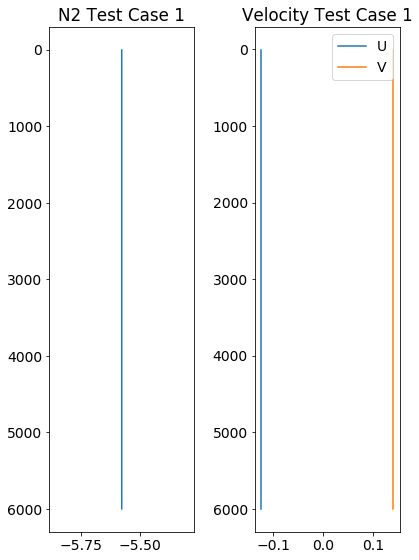

In [5]:
# Create Test case 1 fields 
ladcp, ctd = data_load.load_data()
S, T, p_ctd, lat, lon = oc.loadCTD(ctd)
U, V, p_ladcp = oc.loadLADCP(ladcp)
maxDepth = 6000
idx_ladcp = p_ladcp[:, -1] <= maxDepth
idx_ctd = p_ctd[:, -1] <= maxDepth


S = S[idx_ctd,:]
T = T[idx_ctd,:]

p_ctd = p_ctd[idx_ctd, :]
U = U[idx_ladcp, :]
V = V[idx_ladcp, :]
p_ladcp = p_ladcp[idx_ladcp, :]

N2, N2grid = gsw.Nsquared(S, T, p_ctd)

# N2 field will be mean N2 from towyo transect
N2_mean = np.nanmean(N2, axis=1)
N2_uniform = np.full_like(N2_mean, np.nanmean(N2))

# Create Uniform U and V fields
U_uniform = np.full_like(np.nanmean(U, axis=1), np.nanmean(U))
V_uniform = np.full_like(np.nanmean(V, axis=1), np.nanmean(V))

# Plot profiles to check test fields
plt.figure(figsize=(6,8))
plt.subplot(121)
plt.plot(np.log10(N2_uniform), N2grid[:,0])
plt.gca().invert_yaxis()
plt.title('N2 Test Case 1')

plt.subplot(122)
plt.plot(U_uniform, p_ladcp, label='U')
plt.plot(V_uniform, p_ladcp, label='V')
plt.legend()
plt.gca().invert_yaxis()
plt.title('Velocity Test Case 1')

plt.tight_layout()




In [28]:
# Run test case 1 
print('Test Case 1: Uniform N2 and Flow')
run_tracing_testing(wave, gem, N2_test=N2_uniform,
                    u_test=U_uniform, v_test=V_uniform,
                    n2grid=N2grid[:,0], uvGrid=p_ladcp[:,0],
                    duration=1, tstep=30, time_direction='reverse', status=False)

fig1 = rt.plot_results(wave.results, gem, ms=200, buffer=.1, cls=30, testing=True)


Test Case 1: Uniform N2 and Flow
[0.]
[0.]
[0.]
dx error
N2: 2.654861244649613e-06
k: [nan]
Omega: [nan]
u: -0.12380466633991603
1


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 2

### Test Case 1 Notes:

## Test Case 2: Depth Varying N2, Constant U



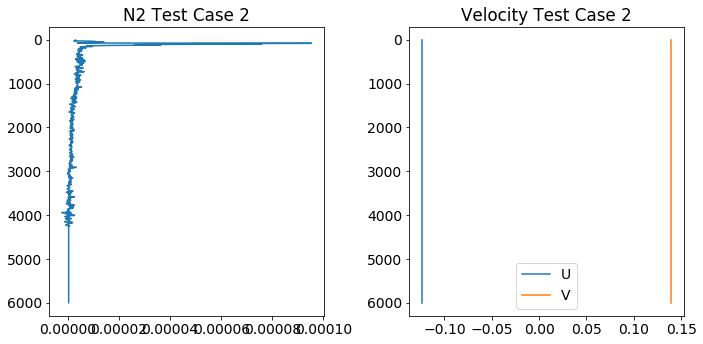

In [189]:
# Test Case 2: Depth Varying
# mean N2 profile across towyo transect is used as the depth varying N2
# that is extrapolated onto the same depth grid as U and V
mask = np.isfinite(N2_mean)
N2f = interp.interp1d(N2grid[:,0][mask], N2_mean[mask],kind='nearest', fill_value='extrapolate')
N2_dvary = N2f(p_ladcp[:,0])
# Plot test Profiles

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(N2_dvary, p_ladcp)
plt.gca().invert_yaxis()
plt.title('N2 Test Case 2')

plt.subplot(122)
plt.plot(U_uniform, p_ladcp, label='U')
plt.plot(V_uniform, p_ladcp, label='V')
plt.legend()
plt.gca().invert_yaxis()
plt.title('Velocity Test Case 2')



plt.tight_layout()

In [430]:
print('Test Case 2: Uniform N2 and Flow')
run_tracing_testing(wave, gem, N2_test=N2_dvary,
                    u_test=U_uniform, v_test=V_uniform,
                    n2grid=p_ladcp[:,0], uvGrid=p_ladcp[:,0],
                    duration=24, tstep=30, time_direction='reverse', status=False)

Test Case 2: Uniform N2 and Flow
Latitude error


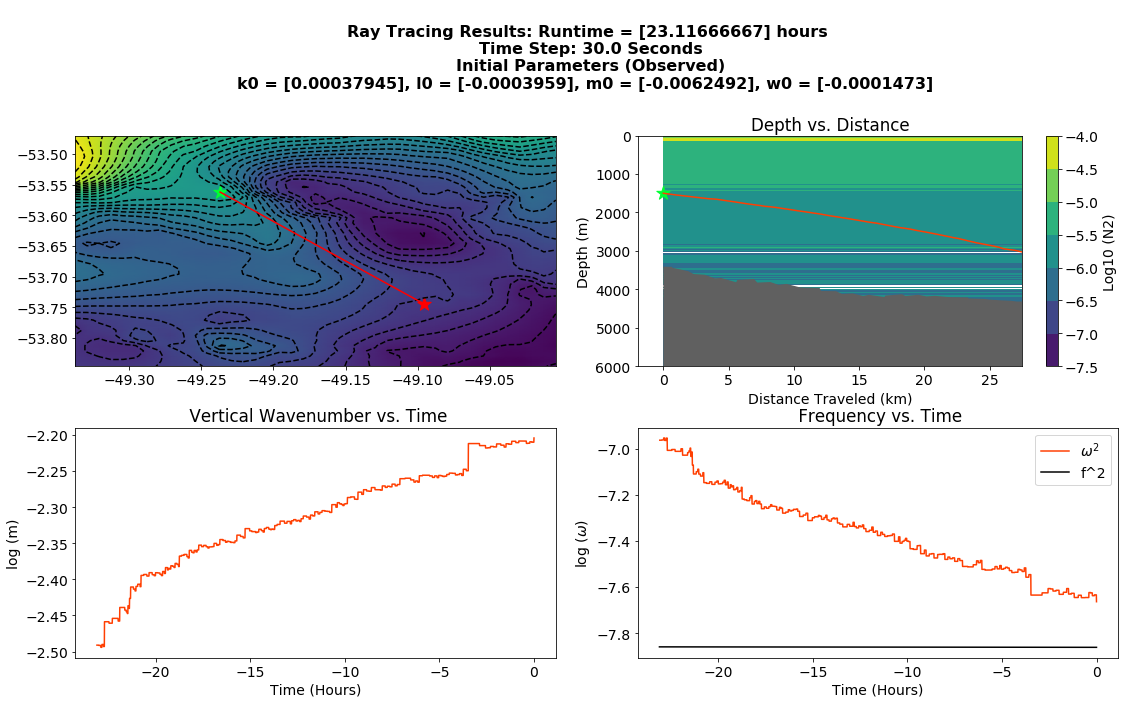

In [431]:
fig2 = rt.plot_results(wave.results, gem, ms=200, buffer=.1, cls=30, testing=True)

## Ray tracing on NOC unix machines
- create gradient files in unix matlab
    - This seems to be difficult in matlab due to version syntax changes in matlab 
- figure out better way of interpolation
